# Choice of $\delta_{SC}$

We know that all the parameters that we sestimate in our model are identifiable. What about the parameter that we don't estimate ($\delta_{SC}$)? From the dynamics of the system, and the result of the commitment experiment, we know an upper and a lower bound for its value, but can't really estimate it precisely.

$ \rho_S + \frac{1}{2}ln (S_0) \, < \, \delta_{SC}  \, < \, \rho_S + ln (S_0)$

This notebook shows how the model behaves for different values of $\delta_{SC}$ taken between these bounds. First it estimates the parameters of the model for the range of values that $\delta_{SC}$ can take. Then it plots the likelihood of the model, and the variations of the parameter values, over this range.

In [1]:
from jupyterthemes import get_themes
from jupyterthemes.stylefx import set_nb_theme

def update_theme(change):
    """ display chosen theme from dropdown menu """
    name = change['new']
    html_css = set_nb_theme(name)
    display(html_css)

themes = get_themes()
print(themes)
set_nb_theme(themes[2])

['chesterish', 'grade3', 'oceans16', 'onedork']


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import rc
%matplotlib inline

rc('text', usetex=False)
rc('font', **{'family': 'sans-serif', 'sans-serif':'DejaVu Sans'})
rc('mathtext', **{'fontset': 'custom', 'rm':'DejaVu Sans', 'it':'DejaVu Sans:italic', 'bf':'DejaVu Sans:bold'})

In [3]:
from imp import reload
import numpy as np
from scipy.stats import chi2
import SCB_estimate as SCBe
import Error_Model as EM
import Custom_Estimation_Routines as CER
import Selection_Criteria as SC
import Profile_Likelihood as PL
reload(CER)

data = '../data/Cell_counts_DMSO.csv'  #path to dataset
duration = 5                           #how many timepoints should we consider in the estimation

DMSO_data = np.genfromtxt(data)
DMSO_data = DMSO_data[:,:duration]
t=np.arange(duration)

rhoS,deltaSC,b1,rhoC,deltaCB,muB,b2 = np.loadtxt('../data/02_Error_Model_Selection/Proportional_Error_%id.params'%(duration-1))
deltaSC_min = rhoS + 0.5 * np.log(DMSO_data[0,0])
deltaSC_max = rhoS + np.log(DMSO_data[0,0])
print(deltaSC_min,deltaSC_max)

n=20 #number of values that we test for delta_SC
DeltaSC=np.linspace(deltaSC_min,deltaSC_max,n)

#Optimization parameters:
nruns=500 #number of independent runs of the second optimization step
LHS=False #should we perform LHS on initial guesses (apparently, it's not working very well with proportional error)
maxiter=int(1e6)  #maximum duration (in evaluations of the model) of one run

5.59075393217 10.6540694841


In [5]:
Likelihood=np.empty(n)
Parameters=np.empty((4,n))

for i in range(n):
    deltaSC=DeltaSC[i]
    opt=CER.Sample_Estimate(EM.logLikelihood_ProportionalError,
                         4,
                         (DMSO_data[1:],SCBe.TB,t,[DMSO_data[1,0],0,0],np.array([rhoS,deltaSC]),False),
                         bounds=((None,None),(0,None),(None,None),(0,None)),
                         nsamples=nruns,
                         lhs=LHS,
                         maxeval=maxiter,
                         full_output=True,
                         verbose_success=False,
                         verbose_error=False)
    Parameters[:,i]=opt['parameters']
    Likelihood[i]=opt['error']
    print('%i:\t%.4g'%(i,opt['error']))


0:	173.9
1:	173.9
2:	173.9
3:	173.9
4:	173.8
5:	173.8
6:	173.8
7:	173.8
8:	173.8
9:	173.8
10:	173.8
11:	173.7
12:	173.7
13:	173.7
14:	173.7
15:	173.7
16:	173.7
17:	173.7
18:	173.7
19:	173.7


In [6]:
save=False
if save:
    np.savetxt('../data/04_Choice_of_deltaSC/deltaSC_likelihood_%id.csv'%(duration-1),Likelihood)
    np.savetxt('../data/04_Choice_of_deltaSC/deltaSC_parameters_%id.params'%(duration-1),Parameters)
               
load=True
if load:
    Likelihood=np.genfromtxt('../data/04_Choice_of_deltaSC/deltaSC_likelihood_%id.csv'%(duration-1))
    Parameters=np.genfromtxt('../data/04_Choice_of_deltaSC/deltaSC_parameters_%id.params'%(duration-1))

/Users/rduchesn/Library/Python/3.5/lib/python/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/rduchesn/Library/Python/3.5/lib/python/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['DejaVu Sans'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/rduchesn/Library/Python/3.5/lib/python/site-packages/matplotlib/mathtext.py:857: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


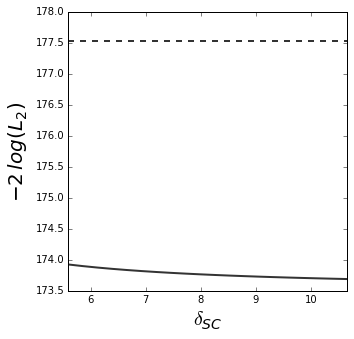

In [7]:
plt.rcParams['figure.figsize']=5,5

threshold=np.min(Likelihood) + chi2.ppf(0.95,1)
plt.plot(DeltaSC,Likelihood,'-',c='0.2',linewidth=2)
plt.plot([DeltaSC[0], DeltaSC[-1]],[threshold, threshold], '--', c='0.2', linewidth=2)
plt.xlim(DeltaSC[0], DeltaSC[-1])
plt.xlabel(r'$\delta_{SC}$', fontsize=20)
plt.ylabel(r'$-2 \, log(L_2)$', fontsize=20)

savefig=False
if savefig:
    plt.savefig('../figures/04_Choice_of_deltaSC/deltaSC_likelihood_%id.pdf'%(duration-1),dpi='figure',bbox_inches='tight')

In [11]:
path2PL = '../data/03_Identifiability_Analysis'
Par=('rhoC', 'deltaCB', 'rhoB', 'b2')
CI=[]
for i in range(4):
    par=Par[i]
    data=np.genfromtxt('%s/%s_%id.profile'%(path2PL,par,(duration-1)))
    PLpar={'Parameters':data[:-1],'Profile_Likelihood':data[-1]}
    CI+= [PL.Confidence_Interval(PLpar, i)]
print(CI)

[(0.048892307413133565, 0.79449999546342231), (0.10955953425327009, 0.33780856394758352), (0.4352807539656206, 1.2600232351636376), (0.081356954885565241, 0.40678477442782573)]


/Users/rduchesn/Library/Python/3.5/lib/python/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/rduchesn/Library/Python/3.5/lib/python/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['DejaVu Sans'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/rduchesn/Library/Python/3.5/lib/python/site-packages/matplotlib/mathtext.py:857: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


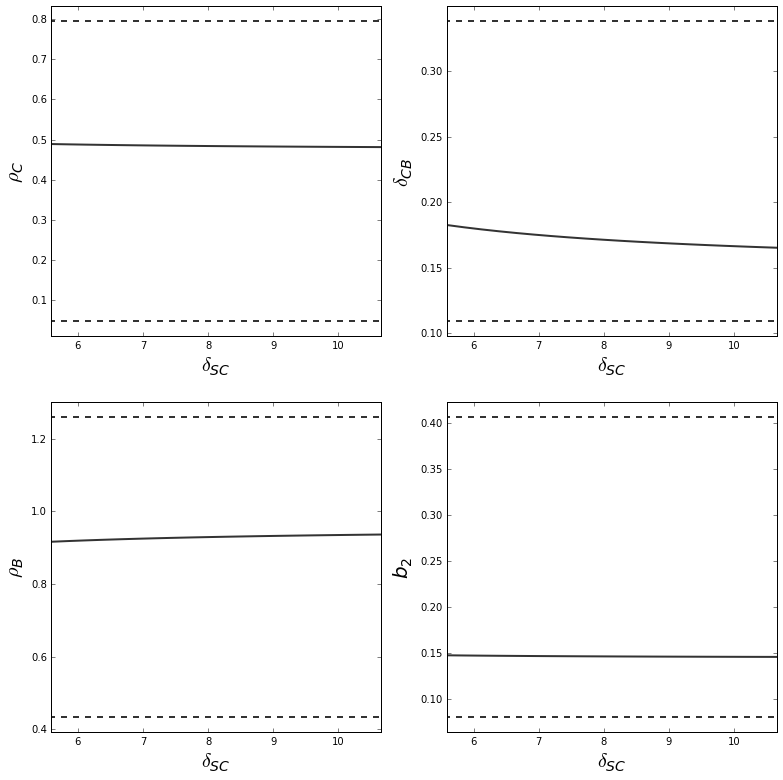

In [10]:
plt.rcParams['figure.figsize']=13,13
f,ax=plt.subplots(2,2)

ylabs=[r'$\rho_C$',r'$\delta_{CB}$',r'$\rho_B$',r'$b_2$']
for i in range(2):
    for j in range(2):
        k=2*i+j
        ax[i,j].plot(DeltaSC,Parameters[k],'-',c='0.2',linewidth=2)
        ax[i,j].plot(ax[i,j].get_xlim(), [CI[k][0], CI[k][0]], '--', c='0.2', linewidth=2)
        ax[i,j].plot(ax[i,j].get_xlim(), [CI[k][1], CI[k][1]], '--', c='0.2', linewidth=2)
        ax[i,j].set_xlim(DeltaSC[0], DeltaSC[-1])
        yrange=CI[k][1]-CI[k][0]
        ax[i,j].set_ylim(CI[k][0]-0.05*yrange, CI[k][1]+0.05*yrange)
        ax[i,j].set_xlabel(r'$\delta_{SC}$',fontsize=20)
        ax[i,j].set_ylabel(ylabs[k],fontsize=20)
        
savefig=False
if savefig:
    plt.savefig('../figures/03_Identifiability_Analysis/deltaSC_parameters_%id.pdf'%(duration-1),dpi='figure',bbox_inches='tight')